In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from datetime import datetime
import seaborn as sns
import pandas as pd
import threading

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [20]:
mapping = [
           'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball',
           'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap',
           'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire',
           'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer',
           'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser', 'drill',
           'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck', 'hockey_stick', 'horse',
           'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket',
           'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
           'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain', 'rainbow',
           'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine', 'watermelon',
]
exclude_names = ['bandage','parrot','blackberry','bottlecap','cake','calendar','camouflage','circle']
exclude = [mapping.index(x) for x in exclude_names]

In [4]:
NUM_OBJECTS = len(mapping)

In [5]:
class Generator():
    def __init__(self,filenames,labels,batch_size,device,max_batch_cache_size=64, max_batch_cache_extend_size=16):
        self.image_filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.device = device
        self.batch_cache = []
        self.active_threads = set()
        self.max_batch_cache_size = max_batch_cache_size
        self.max_batch_cache_extend_size = max_batch_cache_extend_size
        self.batches_loaded = 0
        self.lock_threads = False
        self.cache_in_progress = False
        
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
    
    def load_batch(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        images = []
        for fname in batch_x:
            with open(fname,"rb") as f:
                images.append(np.divide(np.load(f).astype("float32"),255.0))#normalize pixel values
        self.batch_cache.append(
            (torch.tensor(np.array(images),device=self.device).permute(0,3,1,2), torch.tensor(np.array(batch_y),device=self.device))
            )
        try:
            if not self.lock_threads:
                self.active_threads.remove(threading.current_thread())
            #print("Thread finished")
        except Exception as e:
            print(e)
            
        return
    
    def cache_batches(self):
        if ((len(self.active_threads) > self.max_batch_cache_extend_size) or 
            (len(self.batch_cache) > self.max_batch_cache_size) or 
            self.cache_in_progress):
            return
        
        self.cache_in_progress = True
        batches_needed = min(self.max_batch_cache_size - len(self.batch_cache),self.max_batch_cache_extend_size)

        for _ in range(min(batches_needed,len(self) - self.batches_loaded)): 
            thread = threading.Thread(target=self.load_batch, args=(self.batches_loaded,))
            self.active_threads.add(thread)
            self.batches_loaded += 1
            thread.start()
        self.cache_in_progress = False
        

    def __getitem__(self, idx) :
        self.load_batch(idx)
        return self.batch_cache.pop(0)

    def kill_threads(self):
        self.lock_threads = True
        for thread in self.active_threads.copy():
            thread.join()
        self.lock_threads = False
        self.active_threads = set()
        
    def flow(self):
        self.kill_threads()
        self.batches_loaded = 0
        self.batch_cache = []
    
        for i in range(self.__len__()):
            cb = threading.Thread(target=self.cache_batches)
            cb.start()
            while len(self.batch_cache) == 0:
                continue

            yield self.batch_cache.pop(0)
        self.batches_loaded = 0
        self.kill_threads()

In [6]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='float32')[y]

def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [7]:
from sklearn.model_selection import train_test_split

filenames = []
labels = []
lab = 0
for i in range(NUM_OBJECTS):
    if i in exclude:
        continue
    labels += [lab for _ in range(10_000)]
    lab += 1
    for j in range(10_000):
        filenames.append(f"dataset/images/{i}/{j}.npy")

print(lab+1)
labels = to_categorical(labels,lab+1)

train_X,test_X,train_y,test_y = train_test_split(filenames,labels,test_size=0.1)

train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.22)

train_gen = Generator(train_X,train_y,32,device)
val_gen = Generator(val_X,val_y,16,device)

93


In [13]:
with torch.device(device):
    model = nn.Sequential(
        nn.Conv2d(1, 16, 8,stride=4),
        nn.ReLU(),
        nn.LazyConv2d(32, 4,stride=1),
        nn.ReLU(),
        nn.LazyConv2d(16, 2,stride=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.LazyLinear(1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.LazyLinear(512),
        nn.ReLU(),
        nn.LazyLinear(93),
    )

c:\Users\Jake\anaconda3\envs\gemma\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
def spinner(i):
    return "⡀⡁⡂⡃⡄⡅⡆⡇⡈⡉⡊⡋⡌⡍⡎⡏⡐⡑⡒⡓⡔⡕⡖⡗⡘⡙⡚⡛⡜⡝⡞⡟⡠⡡⡢⡣⡤⡥⡦⡧⡨⡩⡪⡫⡬⡭⡮⡯⡰⡱⡲⡳⡴⡵⡶⡷⡸⡹⡺⡻⡼⡽⡾⡿⢀⢁⢂⢃⢄⢅⢆⢇⢈⢉⢊⢋⢌⢍⢎⢏⢐⢑⢒⢓⢔⢕⢖⢗⢘⢙⢚⢛⢜⢝⢞⢟⢠⢡⢢⢣⢤⢥⢦⢧⢨⢩⢪⢫⢬⢭⢮⢯⢰⢱⢲⢳⢴⢵⢶⢷⢸⢹⢺⢻⢼⢽⢾⢿⣀⣁⣂⣃⣄⣅⣆⣇⣈⣉⣊⣋⣌⣍⣎⣏⣐⣑⣒⣓⣔⣕⣖⣗⣘⣙⣚⣛⣜⣝⣞⣟⣠⣡⣢⣣⣤⣥⣦⣧⣨⣩⣪⣫⣬⣭⣮⣯⣰⣱⣲⣳⣴⣵⣶⣷⣸⣹⣺⣻⣼⣽⣾⣿"[i%192]

def minute_second_format(seconds):
    seconds = int(seconds)
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:03d}m {seconds:02d}s"

def info_string(batch, num_batches, loss, acc, time_elapsed, time_remaining):
    return f"\t{spinner(batch)}Batch {batch}/{num_batches} | Loss: {np.round(loss,4):.4f} | Acc: {np.round(acc,4):.4f}| Elapsed time: {minute_second_format(time_elapsed)} | Est. time left: {minute_second_format(time_remaining)}{' '*10}"

In [15]:
def train_model(
        model:nn.Module,
        train_gen:Generator,
        val_gen:Generator,
        num_epochs:int = 50,
        num_early_stop:int = 5,
        num_lr_decrease:int = 3,
        lr_decrease_multiplier:float = 0.25,
        restore_best_weights:bool=True):
    
    loss_function = torch.nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-5)

    best_accuracy = 0
    best_weights = None

    early_stop_counter = 0

    train_loss_values = []
    train_acc_values = []

    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        
        i = 0
        start_time = datetime.now()
        train_batches_total = len(train_gen)

        train_batch_losses = []
        train_batch_accs = []

        print("\tTraining")
        model.train()  
        for X,y in train_gen.flow():
            opt.zero_grad()
            logits = model(X)
            loss = loss_function(logits, y)
            loss.backward()
            opt.step()

            train_batch_losses.append(loss.item())
            train_batch_accs.append(compute_acc(logits,y.argmax(dim=1)).item())
            i+=1
            sec_training = (datetime.now()-start_time).total_seconds()

            print(
                info_string(
                    i,
                    train_batches_total,
                    np.mean(train_batch_losses),
                    np.mean(train_batch_accs),
                    sec_training,
                    sec_training/i * (train_batches_total-i)
                    ),
                end="\r"
                )
            
        train_loss_values.append(np.mean(train_batch_losses))
        train_acc_values.append(np.mean(train_batch_accs))

        print()
        print("\tValidation")
        model.eval()
        val_batch_losses = []
        val_batch_accs = []
        i = 0
        val_batches_total = len(val_gen)
        start_time = datetime.now()

        for X,y in val_gen.flow():
            logits = model(X)
            loss = loss_function(logits, y)
            val_batch_accs.append(compute_acc(logits,y.argmax(dim=1)).item())
            val_batch_losses.append(loss.item())

            i+=1
            sec_training = (datetime.now()-start_time).total_seconds()
            print(info_string(
                i,
                val_batches_total,
                np.mean(val_batch_losses),
                np.mean(val_batch_accs),
                sec_training,
                sec_training/i * (len(val_gen)-i)),end="\r")
        print()

        val_acc_values.append(np.mean(val_batch_accs))
        val_loss_values.append(np.mean(val_batch_losses))

        if val_acc_values[-1] > best_accuracy:
            best_accuracy = val_acc_values[-1]
            best_weights = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= num_lr_decrease:
            for param_group in opt.param_groups:
                param_group['lr'] *= lr_decrease_multiplier
            print(f"Decreasing learning rate to {opt.param_groups[0]['lr']}")
            early_stop_counter -= 2
            
        if early_stop_counter >= num_early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            if restore_best_weights: 
                model.load_state_dict(best_weights)
            break

    return train_loss_values, train_acc_values, val_loss_values, val_acc_values

In [16]:
try:
    tl,ta,vl,va = train_model(model,train_gen,val_gen,num_epochs=10)
except KeyboardInterrupt:
    print()
    print("Active threads -> ",len(train_gen.active_threads))
    print("Cached batches-> ",len(train_gen.batch_cache))
    train_gen.kill_threads()
    val_gen.kill_threads()
    print("\nKeyboard Interrupt")

Epoch 1
	Training
	⡗Batch 20183/20183 | Loss: 1.4894 | Acc: 0.6081| Elapsed time: 006m 17s | Est. time left: 000m 00s          
	Validation
	⡹Batch 11385/11385 | Loss: 1.0727 | Acc: 0.7142| Elapsed time: 001m 55s | Est. time left: 000m 00s          
Epoch 2
	Training
	⡗Batch 20183/20183 | Loss: 1.0967 | Acc: 0.7072| Elapsed time: 006m 06s | Est. time left: 000m 00s          
	Validation
	⡹Batch 11385/11385 | Loss: 0.9811 | Acc: 0.7391| Elapsed time: 001m 55s | Est. time left: 000m 00s          
Epoch 3
	Training
	⡗Batch 20183/20183 | Loss: 1.0196 | Acc: 0.7257| Elapsed time: 006m 15s | Est. time left: 000m 00s          
	Validation
	⡹Batch 11385/11385 | Loss: 0.9683 | Acc: 0.7429| Elapsed time: 001m 45s | Est. time left: 000m 00s          
Epoch 4
	Training
	⡗Batch 20183/20183 | Loss: 0.9773 | Acc: 0.7364| Elapsed time: 006m 20s | Est. time left: 000m 00s          
	Validation
	⡹Batch 11385/11385 | Loss: 0.9430 | Acc: 0.7490| Elapsed time: 001m 44s | Est. time left: 000m 00s          


<Axes: xlabel='epoch', ylabel='value'>

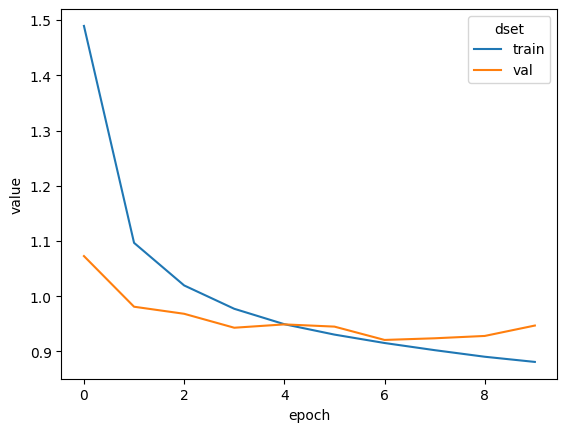

In [17]:
df = pd.concat([
    pd.DataFrame({"dset":["train"]*len(tl),"epoch":list(range(len(tl))),"value":tl}),
    pd.DataFrame({"dset":["val"]*len(vl),"epoch":list(range(len(vl))),"value":vl}),
    ])
sns.lineplot(df,x="epoch",y="value",hue="dset")

<Axes: xlabel='epoch', ylabel='value'>

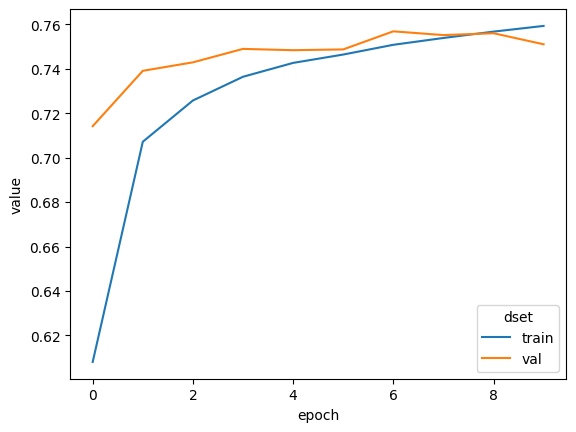

In [18]:
df = pd.concat([
    pd.DataFrame({"dset":["train"]*len(ta),"epoch":list(range(len(ta))),"value":ta}),
    pd.DataFrame({"dset":["val"]*len(va),"epoch":list(range(len(va))),"value":va}),
    ])
sns.lineplot(df,x="epoch",y="value",hue="dset")

(64, 64, 1)


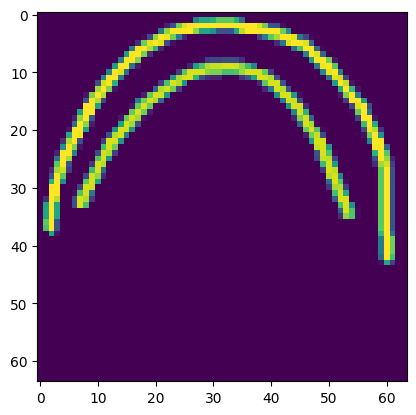

<_MainThread(MainThread, started 12604)>
TRUE: rainbow,PREDICT: rainbow, 99.4%
(64, 64, 1)


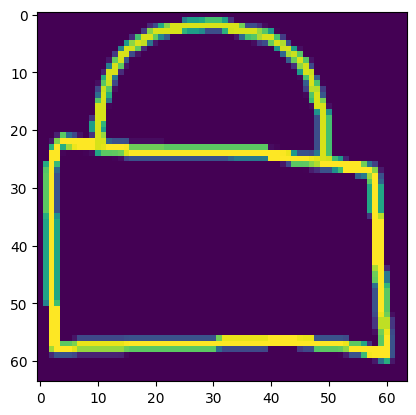

<_MainThread(MainThread, started 12604)>
TRUE: purse,PREDICT: purse, 99.8%
(64, 64, 1)


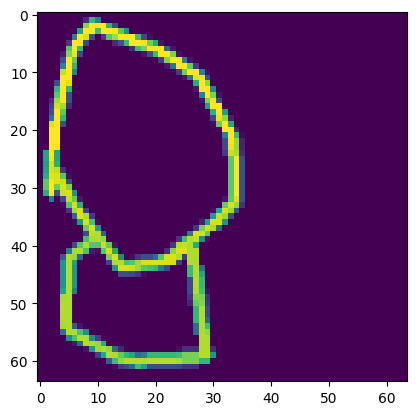

<_MainThread(MainThread, started 12604)>
TRUE: hot_air_balloon,PREDICT: hot_air_balloon, 96.12%
(64, 64, 1)


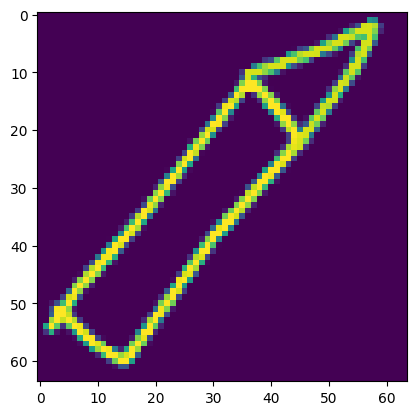

<_MainThread(MainThread, started 12604)>
TRUE: pencil,PREDICT: pencil, 94.15%
(64, 64, 1)


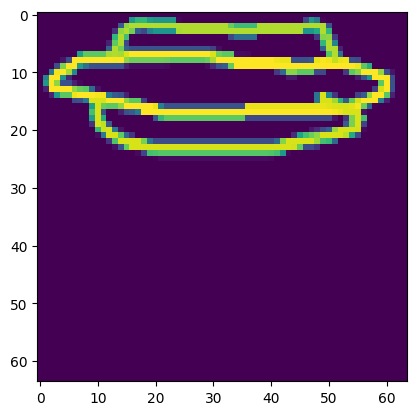

<_MainThread(MainThread, started 12604)>
TRUE: hot_dog,PREDICT: hot_dog, 99.93%
(64, 64, 1)


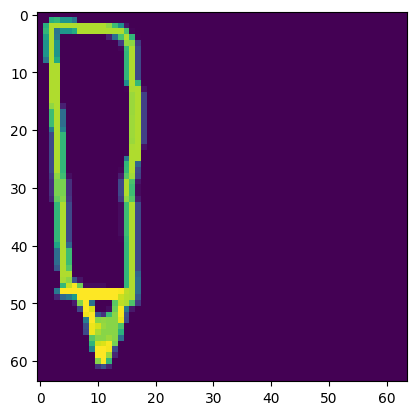

<_MainThread(MainThread, started 12604)>
TRUE: pencil,PREDICT: popsicle, 44.18%
(64, 64, 1)


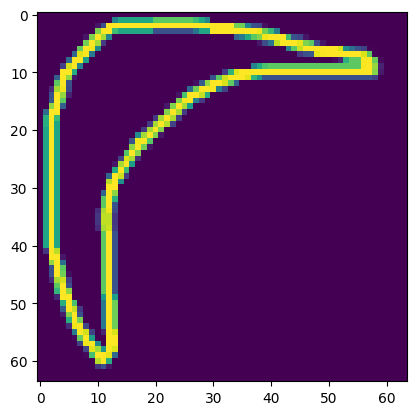

<_MainThread(MainThread, started 12604)>
TRUE: boomerang,PREDICT: boomerang, 97.66%
(64, 64, 1)


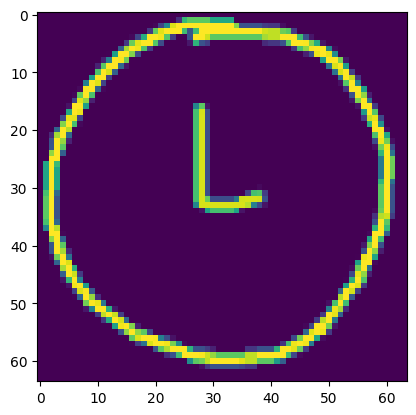

<_MainThread(MainThread, started 12604)>
TRUE: clock,PREDICT: clock, 94.77%
(64, 64, 1)


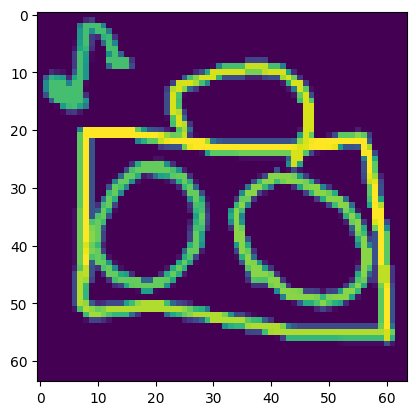

<_MainThread(MainThread, started 12604)>
TRUE: radio,PREDICT: radio, 91.57%
(64, 64, 1)


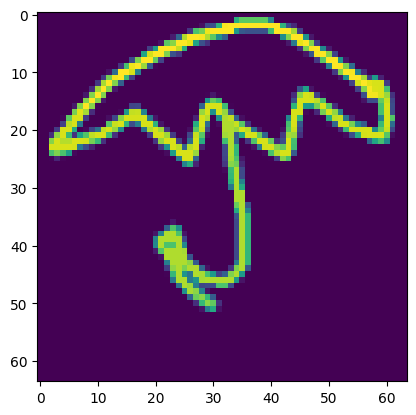

<_MainThread(MainThread, started 12604)>
TRUE: umbrella,PREDICT: umbrella, 98.71%


In [21]:
from matplotlib import pyplot as plt

for i in range(10):
    fname = test_X[i]
    img = None
    with open(fname,"rb") as f:
        img = np.divide(np.load(f),255.0)
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
    label = np.argmax(test_y[i])
    X,y = Generator([fname],[test_y[i]],1,device).__getitem__(0)
    pred = nn.Softmax(1)(model(X))[0].detach().cpu().numpy()
    
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    mapping_left = [x for x in mapping if x not in exclude_names]
    print(f'TRUE: {mapping_left[label]},PREDICT: {mapping_left[pred_label]}, {round(perc*100,2)}%')
    
